# Scenario-Based Forecasting for Revenue Planning  
### Optimistic • Base • Downside Scenarios


## Business Context

Banks and large organisations rely on forward-looking revenue forecasts
to support budgeting, capital allocation, and risk management.

Rather than producing a single-point forecast, this analysis develops
**scenario-based forecasts** to answer practical business questions:

- What happens if demand grows faster than expected?
- What is the downside risk if conditions deteriorate?
- How sensitive revenue projections are to different assumptions?

This approach aligns forecasting outputs with real decision-making needs.


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, pathlib

path = "online_retail_raw.xlsx"

print("Exists:", os.path.exists(path))
print("Size (bytes):", os.path.getsize(path))

with open(path, "rb") as f:
    sig = f.read(8)
print("First 8 bytes:", sig)




Exists: True
Size (bytes): 23740900
First 8 bytes: b'PK\x03\x04\x14\x00\x06\x00'


In [46]:
df = pd.read_excel("online_retail_raw.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


#STEP 1 — Create a  revenue / cashflow series

In [75]:
# Revenue construction
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Remove cancellations / returns (important for realistic cashflow)
df = df[df["Revenue"] > 0]

# Daily revenue (cashflow proxy)
daily_revenue = (
    df
    .set_index("InvoiceDate")["Revenue"]
    .resample("D")
    .sum()
    .asfreq("D", fill_value=0)
)

daily_revenue.head()


,Revenue
InvoiceDate,
2010-12-01,58960.79
2010-12-02,47748.38
2010-12-03,46943.71
2010-12-04,0.00
2010-12-05,31774.95


#STEP 2 — Add a quick sanity-check plot

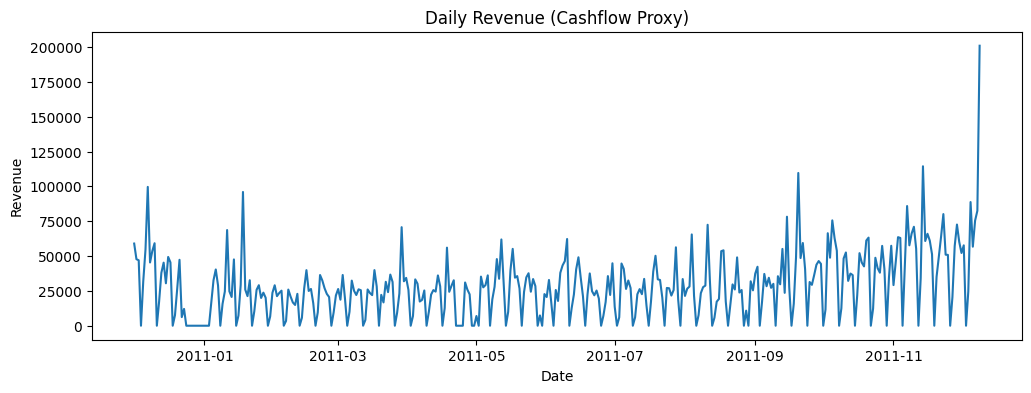

In [49]:
plt.figure(figsize=(12,4))
plt.plot(daily_revenue)
plt.title("Daily Revenue (Cashflow Proxy)")
plt.ylabel("Revenue")
plt.xlabel("Date")
plt.show()


#Insight:
Daily revenue shows strong weekly seasonality with recurring peaks and troughs, alongside increasing volatility toward year-end. Several sharp spikes indicate demand surges or large transactions, highlighting cashflow sensitivity to timing effects and the importance of scenario-based forecasting for risk-aware revenue planning.

#STEP 3 — Train / Test split (explicit & explainable)
## Train / Test Split

The final 60 days are held out to evaluate forecast stability
and scenario sensitivity under recent conditions.


In [50]:
# Hold out last 60 days for scenario evaluation
train = daily_revenue[:-60]
test  = daily_revenue[-60:]

train.shape, test.shape


((314,), (60,))

#STEP 4 — Baseline forecast

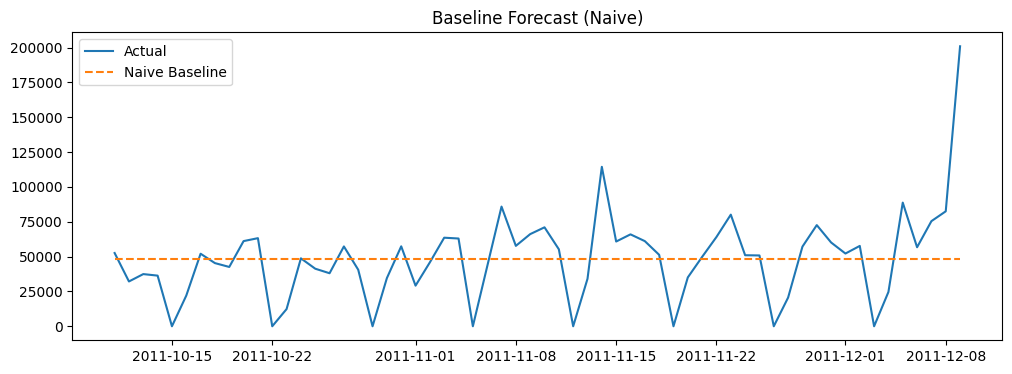

In [51]:
# Naive baseline: last observed value
naive_forecast = np.repeat(train.iloc[-1], len(test))

plt.figure(figsize=(12,4))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, naive_forecast, "--", label="Naive Baseline")
plt.legend()
plt.title("Baseline Forecast (Naive)")
plt.show()


#Insight :
The naïve baseline assumes revenue remains flat at the last observed level, ignoring volatility and recurring weekly patterns. As a result, it systematically underperforms during demand spikes and troughs, highlighting the need for seasonality-aware models to support reliable revenue planning and risk-informed business decisions.

#STEP 5 — Now re-introduce your BEST model

In [76]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
best_forecast = results.forecast(len(test))


#STEP 6 — NOW your scenario code will work

In [77]:
# Scenario assumptions
optimistic_uplift = 0.10   # +10%
downside_shock    = -0.10  # -10%

base = pd.Series(best_forecast, index=test.index)

scenarios = pd.DataFrame({
    "Downside": base * (1 + downside_shock),
    "Base": base,
    "Optimistic": base * (1 + optimistic_uplift)
})

scenarios.head()


,Downside,Base,Optimistic
InvoiceDate,,,
2011-10-11,49072.196705,54524.663006,59977.129307
2011-10-12,49854.234551,55393.593946,60932.953341
2011-10-13,54355.151805,60394.613117,66434.074428
2011-10-14,41566.890658,46185.434064,50803.977471
2011-10-15,6083.993558,6759.992842,7435.992126


#Insight:
Scenario analysis translates the point forecast into decision-ready ranges. A ±10% shock highlights potential upside and downside exposure, enabling risk-aware revenue planning. This framing supports stress testing, capital planning, and contingency decisions rather than relying on a single deterministic forecast.

#STEP 7 — Scenario Fan Chart (Decision Visualization)

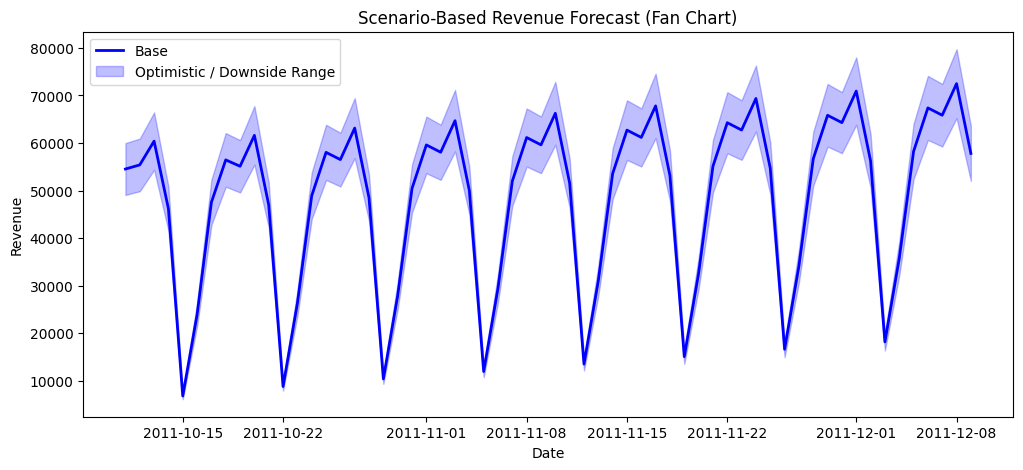

In [78]:
import os
import matplotlib.pyplot as plt

os.makedirs("images", exist_ok=True)

# 🔴 Reset matplotlib state (important in Colab)
plt.close("all")

fig, ax = plt.subplots(figsize=(12,5))

# Base line
ax.plot(
    scenarios.index,
    scenarios["Base"],
    color="blue",
    linewidth=2,
    label="Base"
)

# Fan (must be on same ax)
ax.fill_between(
    scenarios.index,
    scenarios["Downside"],
    scenarios["Optimistic"],
    color="blue",
    alpha=0.25,
    label="Optimistic / Downside Range"
)

ax.set_title("Scenario-Based Revenue Forecast (Fan Chart)")
ax.set_xlabel("Date")
ax.set_ylabel("Revenue")
ax.legend()

# ✅ SAVE THE FIGURE OBJECT (not plt)
fig.savefig(
    "images/scenario_fan_chart.png",
    dpi=200,
    bbox_inches="tight"
)

plt.show()
plt.close(fig)


In [79]:
import os
print("File size:", os.path.getsize("images/scenario_fan_chart.png"), "bytes")


File size: 209615 bytes


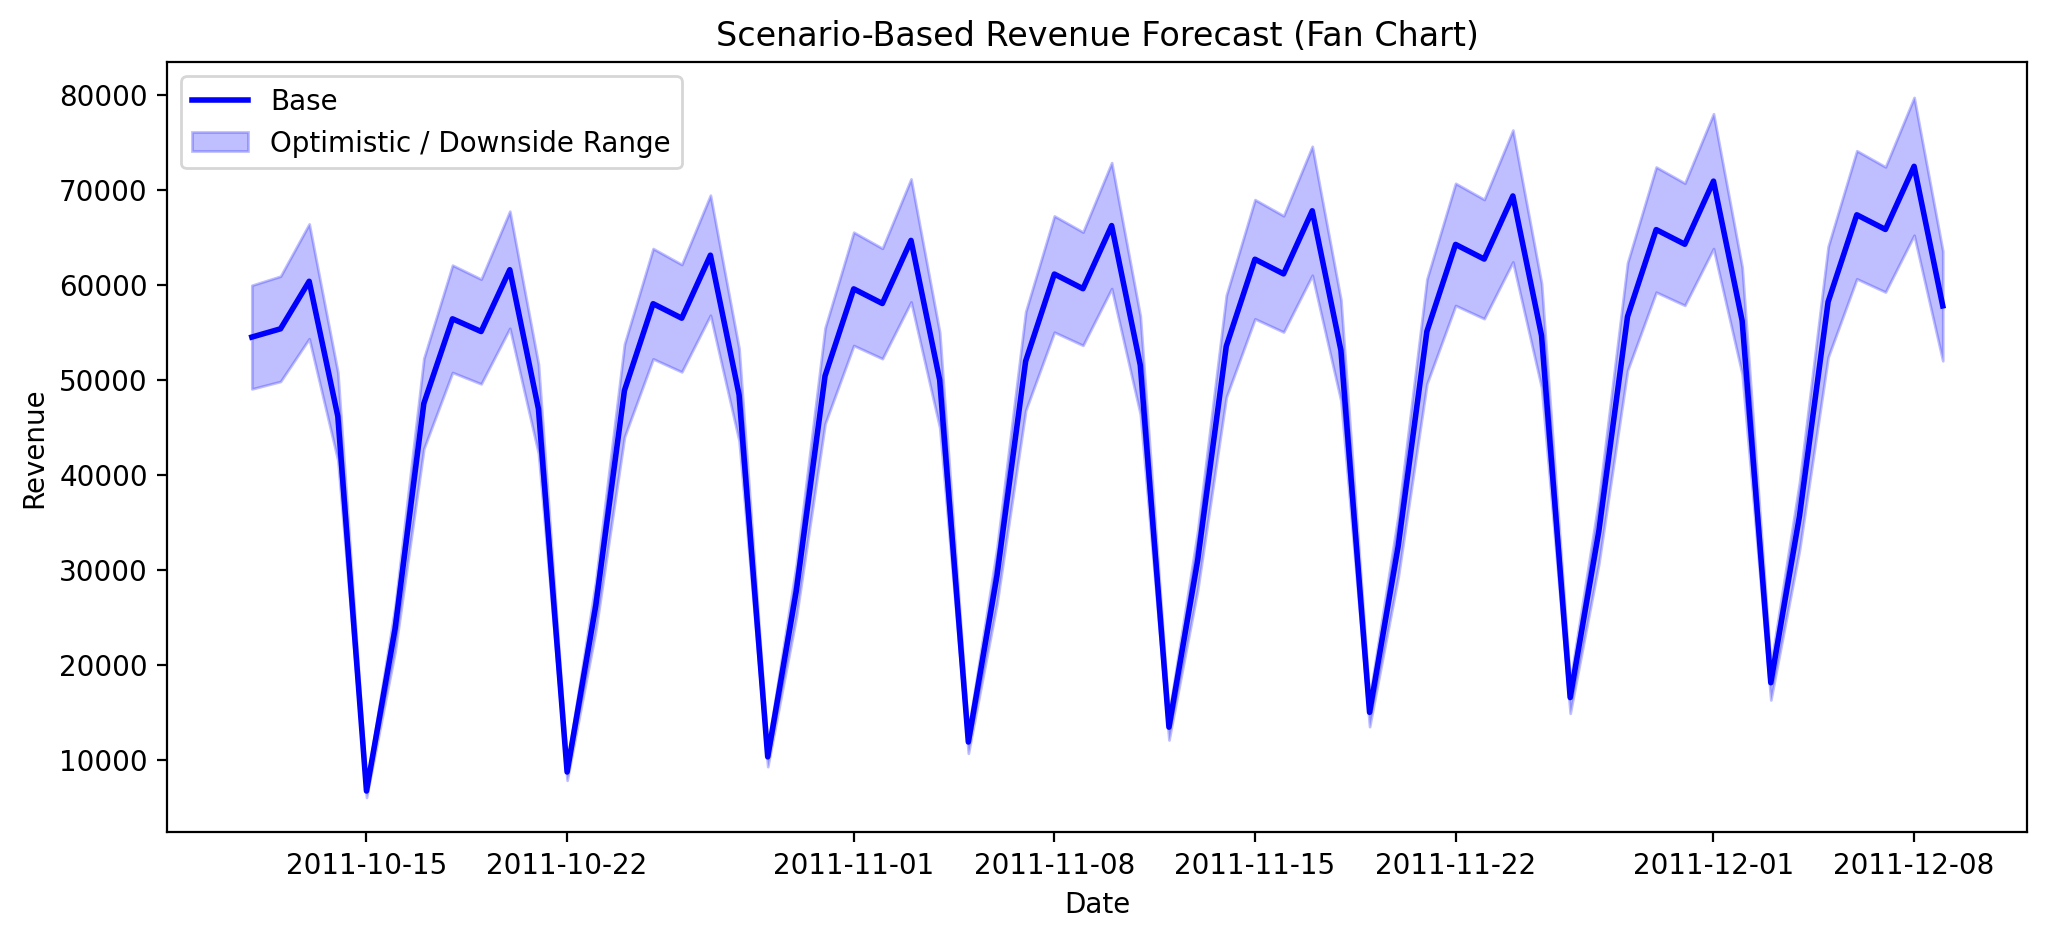

In [80]:
from IPython.display import Image, display
display(Image("images/scenario_fan_chart.png"))


In [81]:
from google.colab import files
files.download("images/scenario_fan_chart.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Insight
The fan chart highlights pronounced weekly seasonality in daily revenue, with recurring troughs and peaks across the forecast horizon. The ±10% optimistic and downside bands show uncertainty widening as revenues grow, indicating increasing risk exposure over time. This scenario range supports stress testing, liquidity planning, and risk-aware revenue forecasting—key requirements for banking and financial institutions

#STEP 8 — Cumulative Revenue Impact (Very Bank-Relevant)

In [69]:
import os
os.makedirs("images", exist_ok=True)


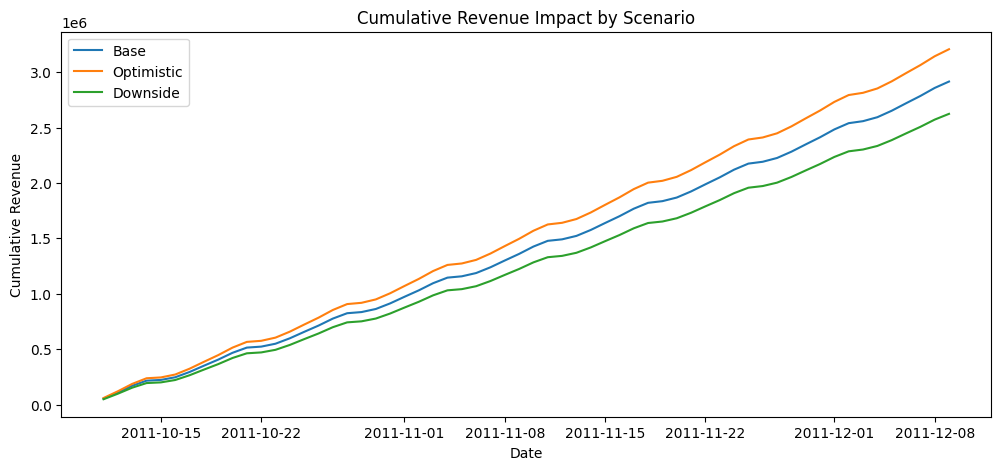

,Downside,Base,Optimistic
InvoiceDate,,,
2011-12-05,2.386073e+06,2.651192e+06,2.916311e+06
2011-12-06,2.446724e+06,2.718583e+06,2.990441e+06
2011-12-07,2.505989e+06,2.784432e+06,3.062875e+06
2011-12-08,2.571229e+06,2.856921e+06,3.142613e+06
2011-12-09,2.623256e+06,2.914729e+06,3.206201e+06


In [83]:
cumulative_impact = scenarios.cumsum()

plt.close("all")
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(cumulative_impact.index, cumulative_impact["Base"], label="Base")
ax.plot(cumulative_impact.index, cumulative_impact["Optimistic"], label="Optimistic")
ax.plot(cumulative_impact.index, cumulative_impact["Downside"], label="Downside")

ax.set_title("Cumulative Revenue Impact by Scenario")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Revenue")
ax.legend()

fig.savefig("images/cumulative_revenue_scenarios.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)

cumulative_impact.tail()


In [85]:
import os
os.makedirs("images", exist_ok=True)


In [84]:
plt.savefig(
    "images/cumulative_revenue_scenarios.png",
    dpi=200,
    bbox_inches="tight"
)


<Figure size 640x480 with 0 Axes>

In [87]:
import os
os.makedirs("images", exist_ok=True)


In [86]:
from google.colab import files
files.download("images/cumulative_revenue_scenarios.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
os.listdir("images")

['cumulative_revenue_scenarios.png', 'scenario_fan_chart.png']

In [89]:
from google.colab import files

files.download("images/scenario_fan_chart.png")
files.download("images/cumulative_revenue_scenarios.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#📌 Insight

The cumulative revenue view highlights the material financial impact of different scenarios over time. By the end of the forecast horizon, the optimistic case exceeds the base scenario by several hundred thousand, while the downside scenario shows a comparable shortfall. This widening gap quantifies upside opportunity and downside risk, supporting capital planning, stress testing, and risk-aware decision-making typical in banking and finance contexts.

#STEP 7 — Turn analysis into a decision narrative
## Business Interpretation & Decision Implications

- The base scenario provides a realistic revenue outlook for short-term planning.
- The optimistic scenario quantifies upside potential under stronger demand conditions.
- The downside scenario highlights potential revenue shortfall under adverse conditions.

**Decision use cases (banking context):**
- Capital and liquidity planning under stress scenarios  
- Budget setting with downside buffers  
- Sensitivity analysis for management decision-making  

This framework enables proactive, risk-aware financial planning rather than reliance on single-point forecasts.
